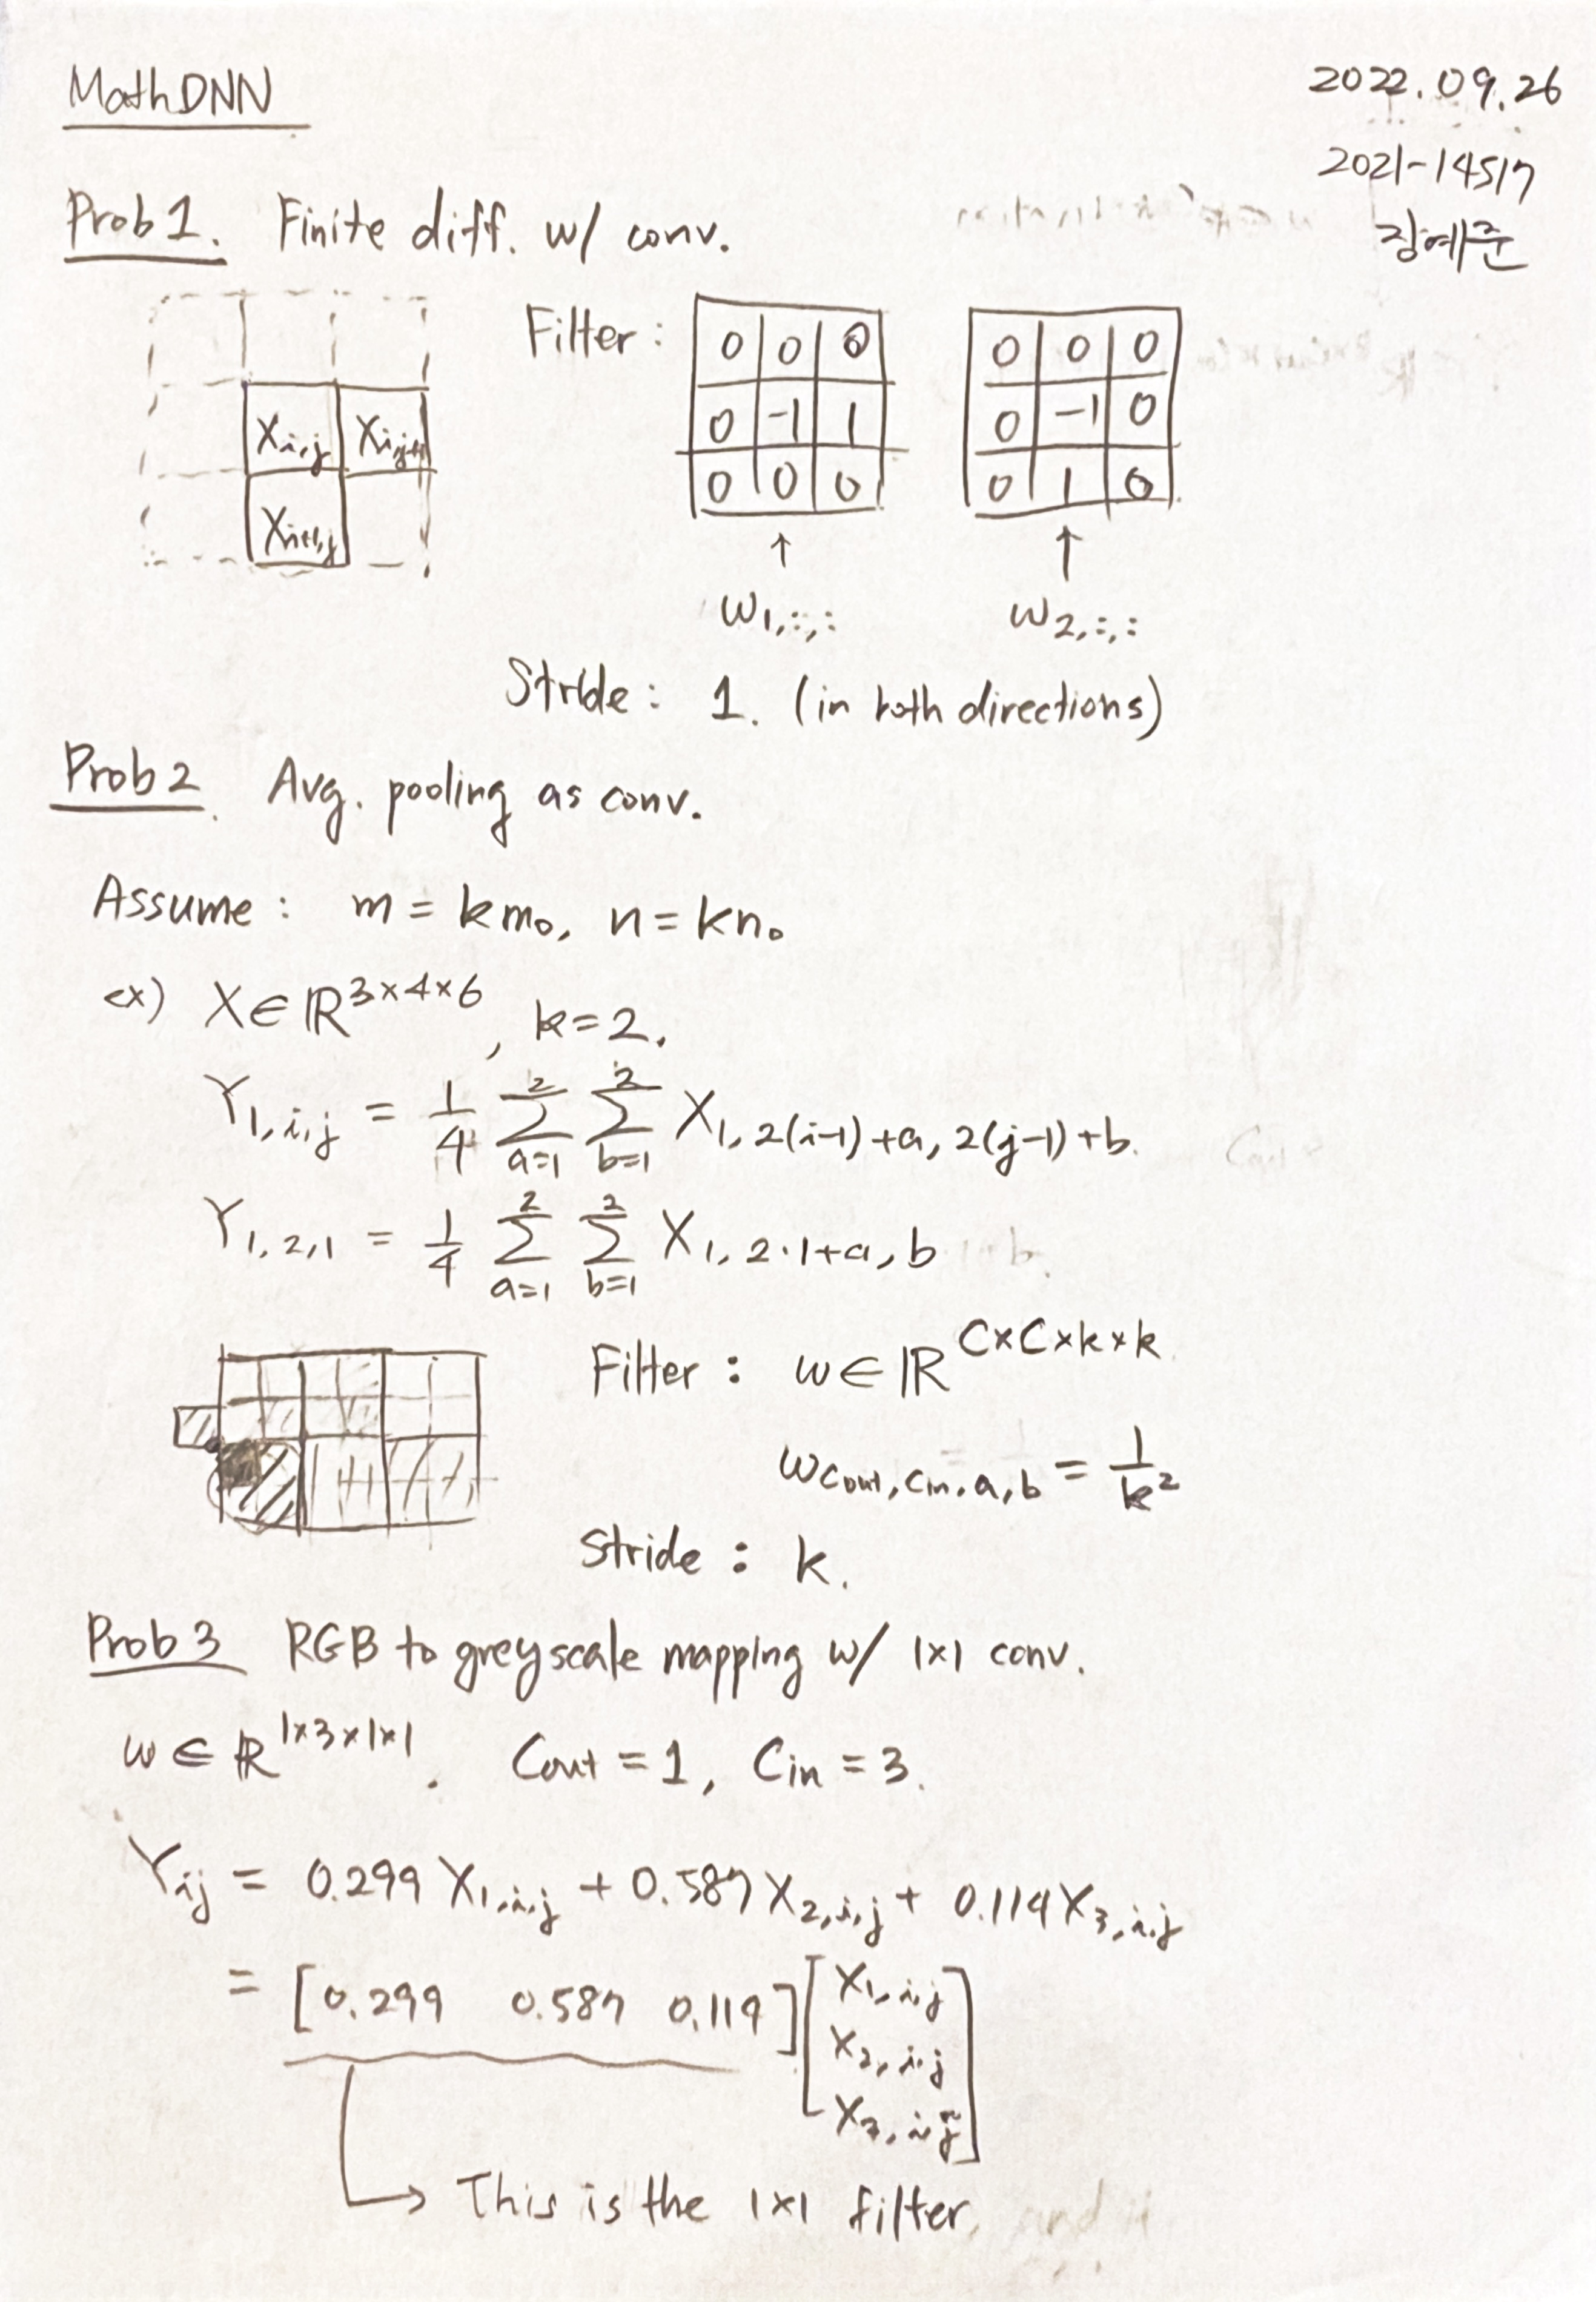

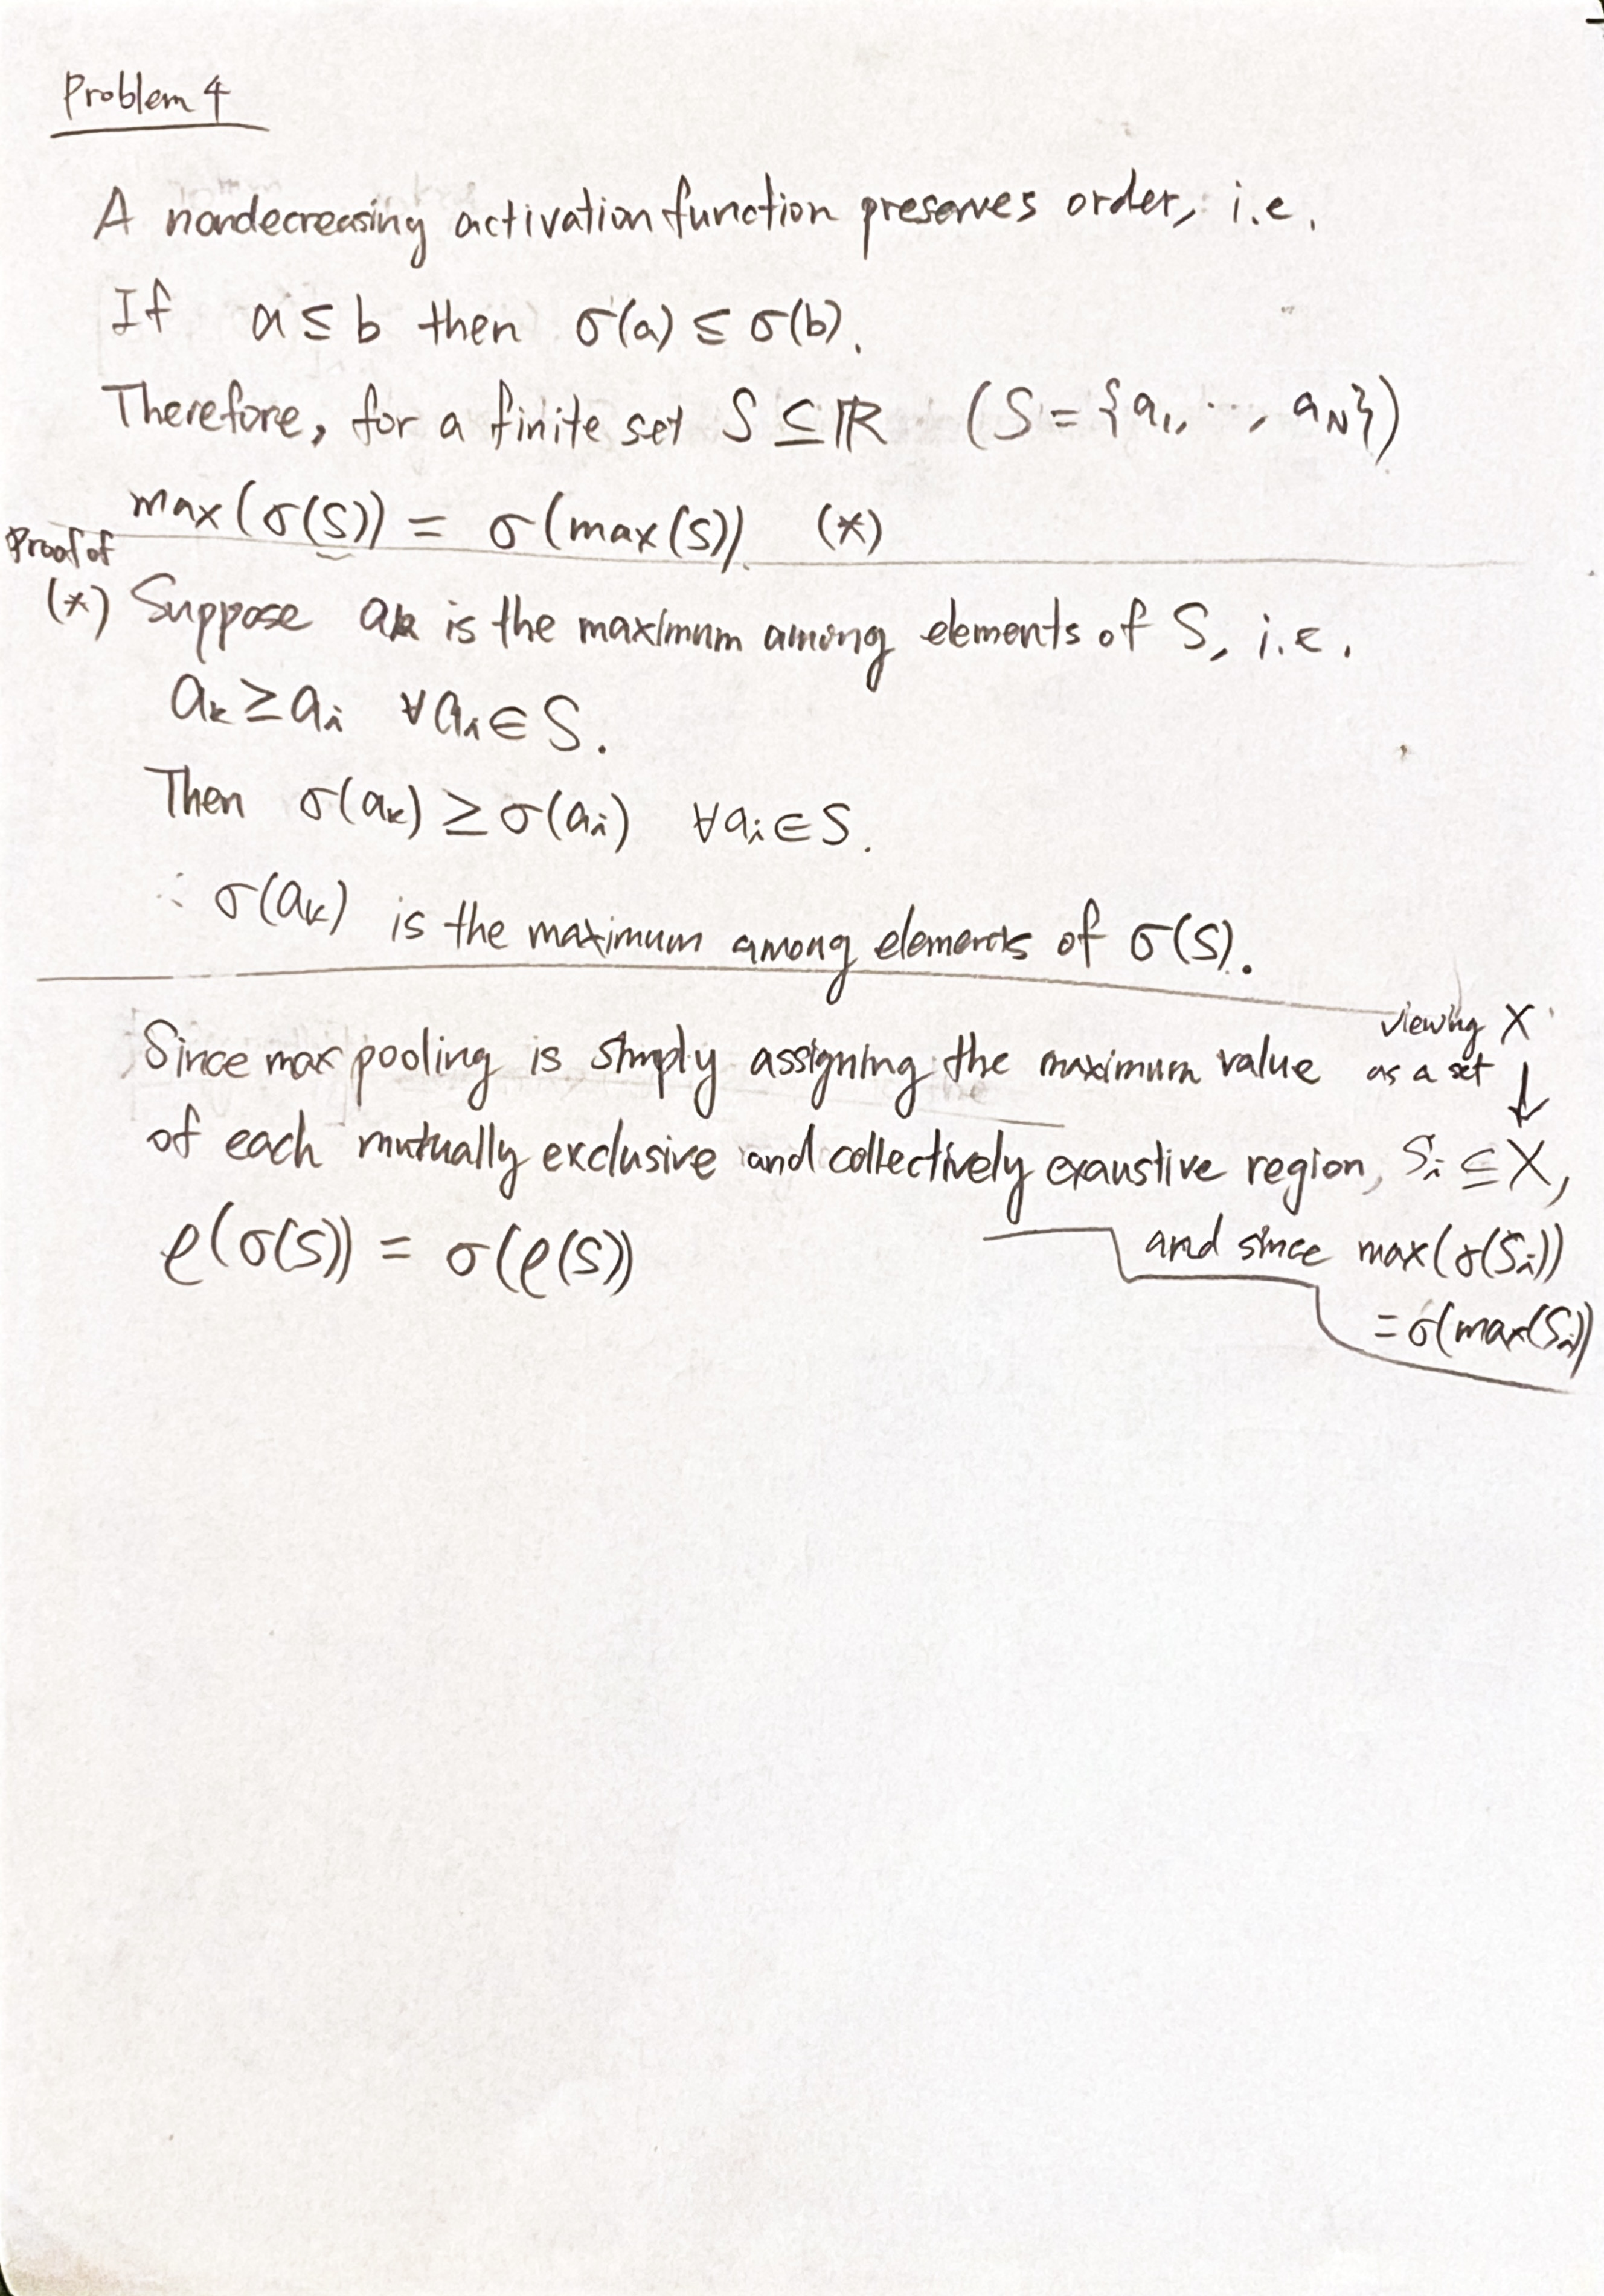

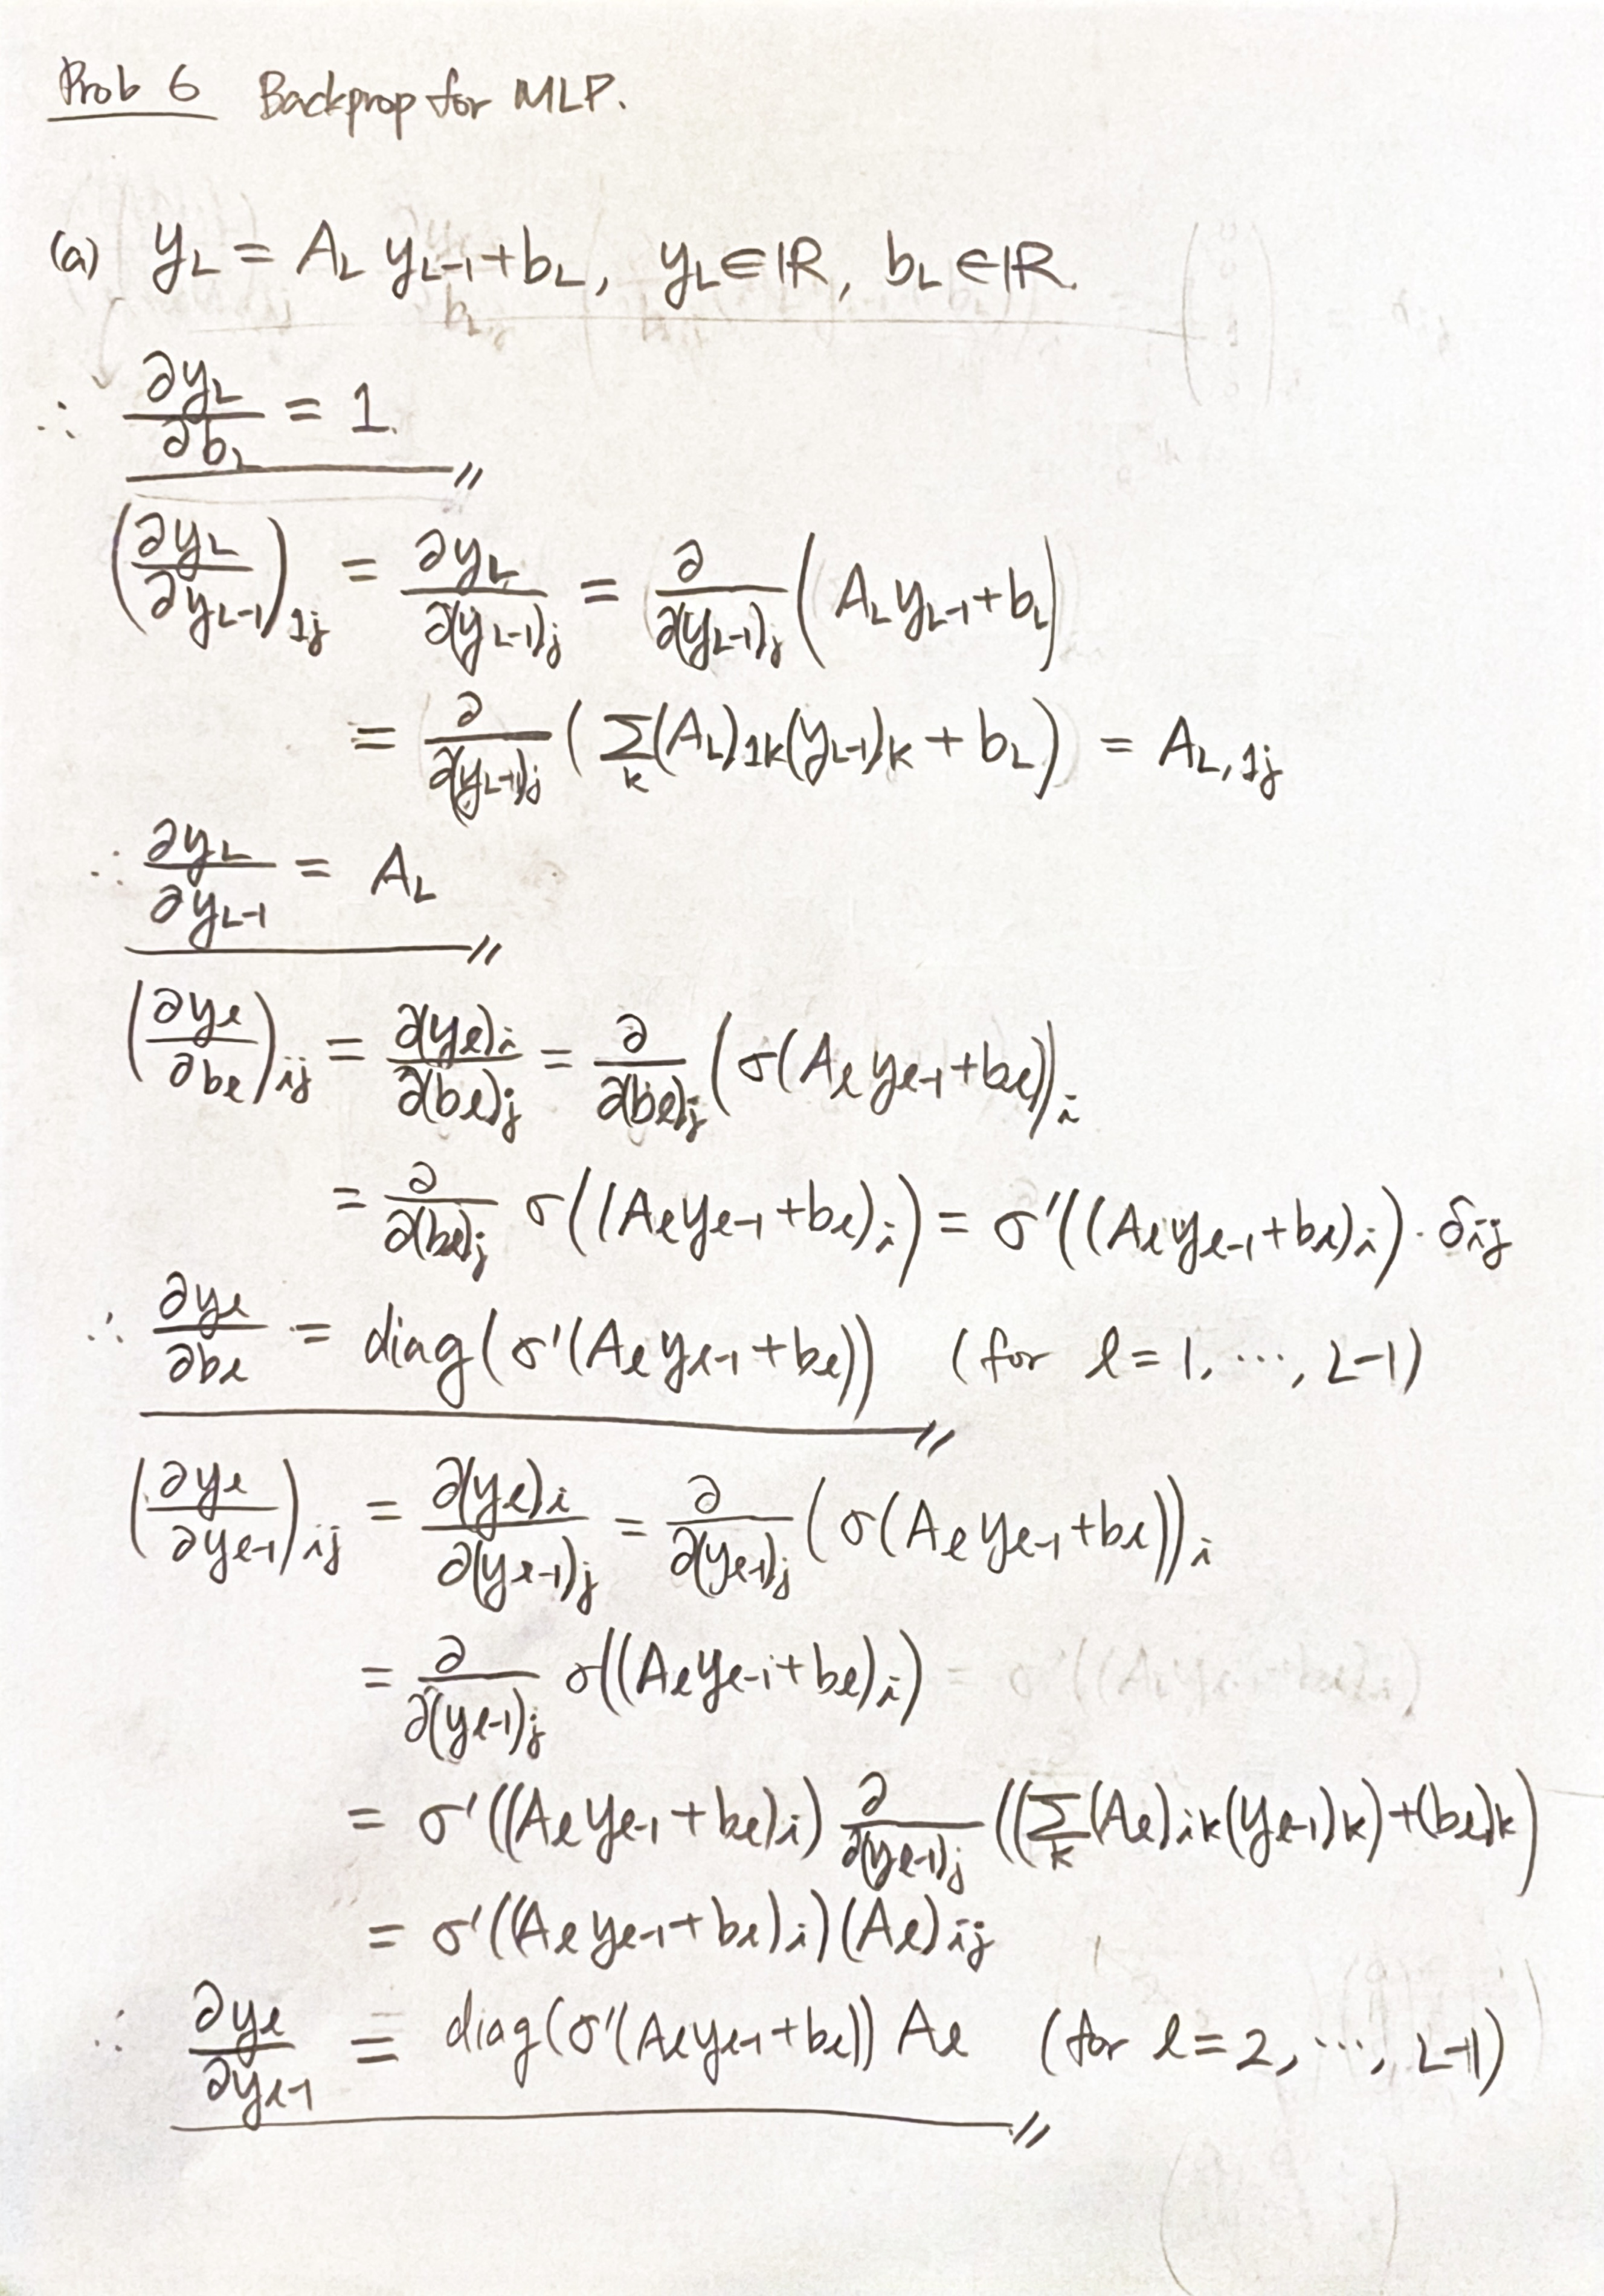

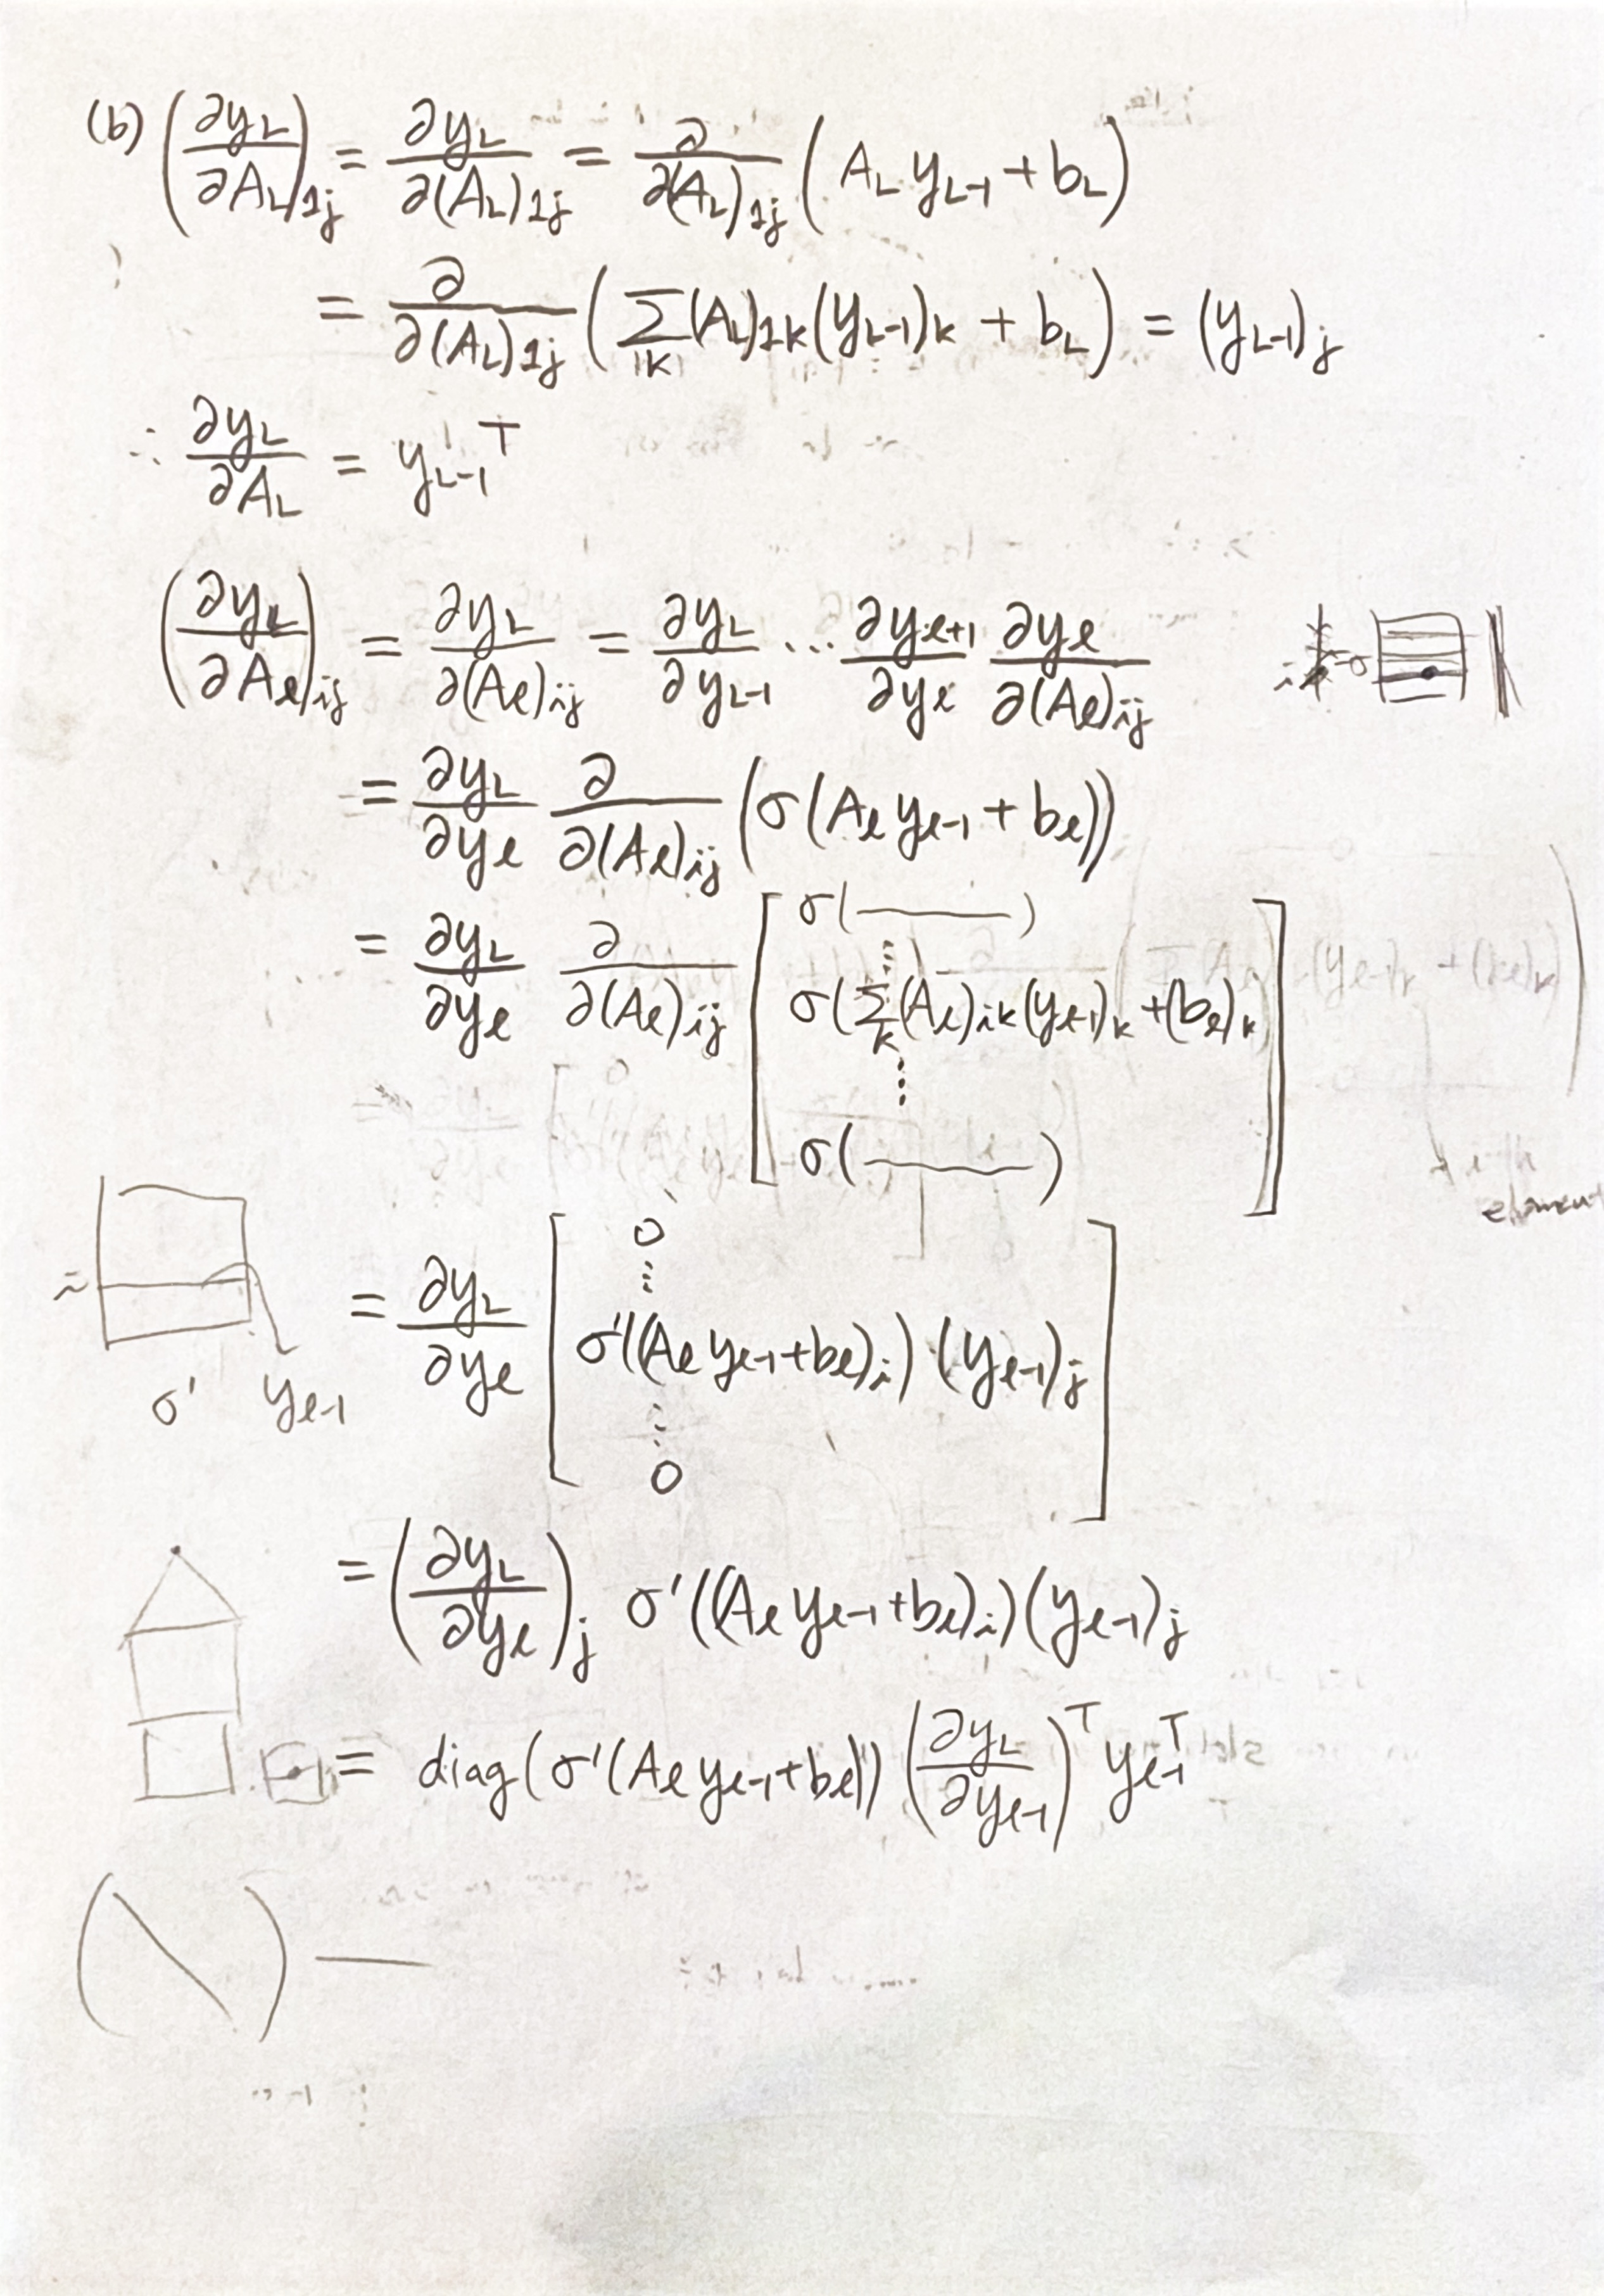

# Problem 5

### with KL divergence

In [1]:
import torch
import torch.nn as nn
from torch.optim import Optimizer
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision.transforms import transforms

from random import randint
from random import shuffle
import numpy as np
import matplotlib.pyplot as plt

is_MSE_loss = False

In [2]:
'''
Step 1: Prepare dataset
'''

label_1, label_2 = 4, 9

train_set = datasets.MNIST(root='./mnist_data', train=True, transform=transforms.ToTensor(), download=True)
idx = (train_set.targets==label_1) + (train_set.targets==label_2)
train_set.data = train_set.data[idx]
train_set.targets = train_set.targets[idx]
train_set.targets[train_set.targets==label_1] = -1
train_set.targets[train_set.targets==label_2] = 1

test_set = datasets.MNIST(root='./mnist_data', train=False, transform=transforms.ToTensor())
idx = (test_set.targets == label_1) + (test_set.targets == label_2)
test_set.data = test_set.data[idx]
test_set.targets = test_set.targets[idx]
test_set.targets[test_set.targets==label_1] = -1
test_set.targets[test_set.targets==label_2] = 1


In [3]:
'''
Step 2: Define the neural network class
'''

class LR(nn.Module):
    def __init__(self, input_dim=28*28):
        super().__init__()
        self.linear = nn.Linear(input_dim, 1, bias=True)
    def forward(self, x):
        return self.linear(x.float().view(-1, 28*28))


In [4]:
'''
Step 3: Create the model, specify loss function and optimizer
'''
model = LR()

def logistic_loss(output, target):
    if is_MSE_loss == False:
        return -torch.nn.functional.logsigmoid(target*output)
    else:
        z, y = output, target
        first_term = 1/2*(1-y)*((1-torch.sigmoid(-z))**2 + torch.sigmoid(z)**2)
        second_term = 1/2*(1+y)*(torch.sigmoid(-z)**2 + (1-torch.sigmoid(z))**2)
        return first_term + second_term

loss_function = logistic_loss
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)


In [5]:
'''
Step 4: Train model with SGD
'''
import time
start = time.time()
for _ in range(1000):
    ind = randint(0, len(train_set.data))
    image, label = train_set.data[ind], train_set.targets[ind]
    
    optimizer.zero_grad()
    
    train_loss = loss_function(model(image), label.float())
    train_loss.backward()
    
    optimizer.step()

end = time.time()
print(f"Time ellapsed in training is: {end-start}")


Time ellapsed in training is: 0.1714479923248291


In [6]:
'''
Step 5: Test model (Evaluate the accuracy)
'''
test_loss, correct = 0, 0
misclassified_ind = []
correct_ind = []

for ind in range(len(test_set.data)):
    image, label = test_set.data[ind], test_set.targets[ind]
    output = model(image)
    test_loss += loss_function(output, label.float()).item()
    
    if output.item() * label.item() >= 0:
        correct += 1
        correct_ind += [ind]
    else:
        misclassified_ind += [ind]

print('[Test set] Average loss: {:.4f}, Accuracy: {}/{} {:.2f}%\n'.format(
test_loss / len(test_set.data), correct, len(test_set.data), 100 * correct / len(test_set.data)
))

[Test set] Average loss: 7.2264, Accuracy: 1868/1991 93.82%



### with MSELoss

In [7]:
'''
Step 3: Create the model, specify loss function and optimizer
'''

is_MSE_loss = True
model = LR()

def logistic_loss(output, target):
    if is_MSE_loss == False:
        return -torch.nn.functional.logsigmoid(target*output)
    else:
        z, y = output, target
        first_term = 1/2*(1-y)*((1-torch.sigmoid(-z))**2 + torch.sigmoid(z)**2)
        second_term = 1/2*(1+y)*(torch.sigmoid(-z)**2 + (1-torch.sigmoid(z))**2)
        return first_term + second_term

loss_function = logistic_loss
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)


In [8]:
'''
Step 4: Train model with SGD
'''
import time
start = time.time()
for _ in range(1000):
    ind = randint(0, len(train_set.data))
    image, label = train_set.data[ind], train_set.targets[ind]
    
    optimizer.zero_grad()
    
    train_loss = loss_function(model(image), label.float())
    train_loss.backward()
    
    optimizer.step()

end = time.time()
print(f"Time ellapsed in training is: {end-start}")


Time ellapsed in training is: 0.3345799446105957


In [9]:
'''
Step 5: Test model (Evaluate the accuracy)
'''
test_loss, correct = 0, 0
misclassified_ind = []
correct_ind = []

for ind in range(len(test_set.data)):
    image, label = test_set.data[ind], test_set.targets[ind]
    output = model(image)
    test_loss += loss_function(output, label.float()).item()
    
    if output.item() * label.item() >= 0:
        correct += 1
        correct_ind += [ind]
    else:
        misclassified_ind += [ind]

print('[Test set] Average loss: {:.4f}, Accuracy: {}/{} {:.2f}%\n'.format(
test_loss / len(test_set.data), correct, len(test_set.data), 100 * correct / len(test_set.data)
))

[Test set] Average loss: 1.0134, Accuracy: 982/1991 49.32%



### Performance comparison, compared to minimizing KL divergence
The performance is much worse when minimizing the MSELoss, compared to  minimizing the KL divergence.
Using MSELoss is a bad idea, especially because of task that the model needs to perform. The problem we're facing is a "binary classification" problem. Using the MSELoss assumes that $Y_i$ can take on continuous values, and that the $Y_i$'s follow a normal distribution centered around some mean value. This isn't the case for binary classification \- the labels are discrete and can take on only two values, i.e. $Y_i$'s follow a Bernoulli distribution with success probability $p\approx0.5$.

# Problem 7
### original LeNet

In [10]:
import torch
import torch.nn as nn
from torch.optim import Optimizer
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import transforms

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
is_original = True  # whether or not the network is in its original form

In [11]:
'''
Step 1:
'''

# MNIST dataset
train_dataset = datasets.MNIST(root='./mnist_data/',
                               train=True, 
                               transform=transforms.ToTensor(),
                               download=True)

test_dataset = datasets.MNIST(root='./mnist_data/',
                              train=False, 
                              transform=transforms.ToTensor())


In [12]:
'''
Step 2: LeNet5
'''

# Modern LeNet uses this layer for C3
class C3_layer_full(nn.Module):
    def __init__(self):
        super(C3_layer_full, self).__init__()
        self.conv_layer = nn.Conv2d(6, 16, kernel_size=5)

    def forward(self, x):
        return self.conv_layer(x)

# Original LeNet uses this layer for C3
class C3_layer(nn.Module):
    def __init__(self):
        super(C3_layer, self).__init__()
        self.ch_in_3 = [[0, 1, 2],
                        [1, 2, 3],
                        [2, 3, 4],
                        [3, 4, 5],
                        [0, 4, 5],
                        [0, 1, 5]] # filter with 3 subset of input channels
        self.ch_in_4 = [[0, 1, 2, 3],
                        [1, 2, 3, 4],
                        [2, 3, 4, 5],
                        [0, 3, 4, 5],
                        [0, 1, 4, 5],
                        [0, 1, 2, 5],
                        [0, 1, 3, 4],
                        [1, 2, 4, 5],
                        [0, 2, 3, 5]] # filter with 4 subset of input channels
        self.ch_in_6 = [[0, 1, 2, 3, 4, 5]]
        self.conv_in_3 = [nn.Conv2d(3, 1, kernel_size=5) for _ in range(6)]
        self.conv_in_4 = [nn.Conv2d(4, 1, kernel_size=5) for _ in range(9)]
        self.conv_in_6 = [nn.Conv2d(6, 1, kernel_size=5)]
        self.channels = self.ch_in_3 + self.ch_in_4 + self.ch_in_6
        self.convs = nn.ModuleList(self.conv_in_3 + self.conv_in_4 + self.conv_in_6)
        
    def forward(self, x):
        extracted_features = []
        for i, conv in enumerate(self.convs):
            idx = self.channels[i]
            extracted_features += [conv(x[:,idx,:,:])]
        return torch.cat(extracted_features, dim=1)
    
class LeNet(nn.Module) :
    def __init__(self) :
        super(LeNet, self).__init__()
        #padding=2 makes 28x28 image into 32x32
        self.C1_layer = nn.Sequential(
                nn.Conv2d(1, 6, kernel_size=5, padding=2),
                nn.Tanh()
                )
        self.P2_layer = nn.Sequential(
                nn.AvgPool2d(kernel_size=2, stride=2),
                nn.Tanh()
                )
        if is_original:
            self.C3_layer = nn.Sequential(
                    # C3_layer_full(),
                    C3_layer(),
                    nn.Tanh()
                    )
        else:
            self.C3_layer = nn.Sequential(
                    C3_layer_full(),
                    # C3_layer(),
                    nn.Tanh()
                    )
        self.P4_layer = nn.Sequential(
                nn.AvgPool2d(kernel_size=2, stride=2),
                nn.Tanh()
                )
        self.C5_layer = nn.Sequential(
                nn.Linear(5*5*16, 120),
                nn.Tanh()
                )
        self.F6_layer = nn.Sequential(
                nn.Linear(120, 84),
                nn.Tanh()
                )
        self.F7_layer = nn.Linear(84, 10)
        self.tanh = nn.Tanh()
        
    def forward(self, x) :
        output = self.C1_layer(x)
        output = self.P2_layer(output)
        output = self.C3_layer(output)
        output = self.P4_layer(output)
        output = output.view(-1,5*5*16)
        output = self.C5_layer(output)
        output = self.F6_layer(output)
        output = self.F7_layer(output)
        return output


In [13]:
'''
Step 3
'''
model = LeNet().to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

# print total number of trainable parameters
param_ct = sum([p.numel() for p in model.parameters()])
print(f"Total number of trainable parameters: {param_ct}")


Total number of trainable parameters: 60806


In [14]:
'''
Step 4
'''
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100, shuffle=True)

import time
start = time.time()
for epoch in range(10) :
    print("{}th epoch starting.".format(epoch))
    for images, labels in train_loader :
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        train_loss = loss_function(model(images), labels)
        train_loss.backward()

        optimizer.step()
end = time.time()
print("Time ellapsed in training is: {}".format(end - start))


0th epoch starting.
1th epoch starting.
2th epoch starting.
3th epoch starting.
4th epoch starting.
5th epoch starting.
6th epoch starting.
7th epoch starting.
8th epoch starting.
9th epoch starting.
Time ellapsed in training is: 277.53085803985596


In [15]:
'''
Step 5
'''
test_loss, correct, total = 0, 0, 0

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=100, shuffle=False)

for images, labels in test_loader :
    images, labels = images.to(device), labels.to(device)

    output = model(images)
    test_loss += loss_function(output, labels).item()

    pred = output.max(1, keepdim=True)[1]
    correct += pred.eq(labels.view_as(pred)).sum().item()
    
    total += labels.size(0)
            
print('[Test set] Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss /total, correct, total,
        100. * correct / total))


[Test set] Average loss: 0.0004, Accuracy: 9852/10000 (98.52%)



### current LeNet

In [16]:
is_original = False  # Testing the current version of LeNet

In [17]:
'''
Step 3
'''
model = LeNet().to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1)

# print total number of trainable parameters
param_ct = sum([p.numel() for p in model.parameters()])
print(f"Total number of trainable parameters: {param_ct}")

Total number of trainable parameters: 61706


In [18]:
'''
Step 4
'''
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100, shuffle=True)

import time
start = time.time()
for epoch in range(10) :
    print("{}th epoch starting.".format(epoch))
    for images, labels in train_loader :
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        train_loss = loss_function(model(images), labels)
        train_loss.backward()

        optimizer.step()
end = time.time()
print("Time ellapsed in training is: {}".format(end - start))

0th epoch starting.
1th epoch starting.
2th epoch starting.
3th epoch starting.
4th epoch starting.
5th epoch starting.
6th epoch starting.
7th epoch starting.
8th epoch starting.
9th epoch starting.
Time ellapsed in training is: 111.1414201259613


In [19]:
'''
Step 5
'''
test_loss, correct, total = 0, 0, 0

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=100, shuffle=False)

for images, labels in test_loader :
    images, labels = images.to(device), labels.to(device)

    output = model(images)
    test_loss += loss_function(output, labels).item()

    pred = output.max(1, keepdim=True)[1]
    correct += pred.eq(labels.view_as(pred)).sum().item()
    
    total += labels.size(0)
            
print('[Test set] Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss /total, correct, total,
        100. * correct / total))

[Test set] Average loss: 0.0004, Accuracy: 9862/10000 (98.62%)



### Reduction in parameter count
16\*6\*5\*5 - (6\*(1\*3\*5\*5) + 9\*(1\*4\*5\*5) + 1\*(1\*6\*5\*5)) = 900\
61706-60806 = 900\
The reduction in parameter count is 900, as expected.